# Resources

* Aladdin Persson:  Variational Autoencoder from scratch in PyTorch

https://www.youtube.com/watch?v=VELQT1-hILo

https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master/ML/Pytorch/more_advanced/VAE


* Implement Deep Autoencoder in PyTorch for Image Reconstruction

Link: https://www.geeksforgeeks.org/implement-deep-autoencoder-in-pytorch-for-image-reconstruction/

* How to Generate Images using Autoencoders

Link: https://towardsdatascience.com/how-to-generate-images-using-autoencoders-acfbc6c3555e


https://medium.com/@rekalantar/variational-auto-encoder-vae-pytorch-tutorial-dce2d2fe0f5f

In [146]:
import torch
from torch import nn
from torchsummary import summary
import torchvision.datasets as datasets
import torch.optim as optim
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
other_data_dir = 'other_data'

In [41]:
data = torch.utils.data.DataLoader(
        datasets.MNIST('./data',
               transform=transforms.ToTensor(),
               download=True),
        batch_size=128,
        shuffle=True)

100%|██████████████████████████████████████████████████████████████████| 9912422/9912422 [00:00<00:00, 26052752.08it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 13992802.80it/s]

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw




100%|██████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 14706808.48it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [47]:
batch_size = 32
workers = 4
shuffle = True

dataset = datasets.MNIST(root = other_data_dir, 
                         train = True, 
                         transform = transforms.Compose([
                             transforms.ToTensor(),
                         ]),
                         download=True)

dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size,
                                         shuffle = shuffle, num_workers = workers)

In [45]:
def _my_normalization(x):
    return (x + 1) / 2

In [48]:
a, b = next(iter(data))

In [49]:
print(a.shape, torch.min(a), torch.max(a))

torch.Size([128, 1, 28, 28]) tensor(0.) tensor(1.)


In [176]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
input_dim = 28*28
h_dim = 200
z_dim = 20

model = VariationalAutoEncoder(input_dim, h_dim, z_dim).to(device)
summary(model, (1, input_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 200]         157,000
              ReLU-2               [-1, 1, 200]               0
            Linear-3                [-1, 1, 20]           4,020
            Linear-4                [-1, 1, 20]           4,020
            Linear-5               [-1, 1, 200]           4,200
              ReLU-6               [-1, 1, 200]               0
            Linear-7               [-1, 1, 784]         157,584
Total params: 326,824
Trainable params: 326,824
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.25
Estimated Total Size (MB): 1.26
----------------------------------------------------------------


In [177]:
learning_rate = 0.0001

optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.BCELoss(reduction = "sum")

In [178]:
n_epochs = 25

In [180]:
model.train()
n_batch_train = len(dataloader)
n_train = n_batch_train*batch_size

for epoch in range(n_epochs):
    
    overall_loss = 0
    
    with tqdm(total=n_train, desc=f'Epoch {epoch+1}/{n_epochs}', unit='Sample(s)') as pbar:                
        for i, (image,_) in enumerate(dataloader):
    
            image = image.view(batch_size, input_dim).to(device)
            image = (image - torch.min(image))/(torch.max(image) - torch.min(image))

            optimizer.zero_grad()

            image_reconstructed, mu, sigma = model(image)

            #loss = criterion(x, x_reconstructed, mean, log_var) for kl divergence
            #loss = criterion(x, x_reconstructed)
            #re_loss = ((image - image_reconstructed)**2).sum()
            #kl_div = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
            loss = ((image - image_reconstructed)**2).sum()

            overall_loss += loss.item()

            loss.backward()
            optimizer.step()
            
            pbar.update(batch_size)

    print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(i*batch_size))

Epoch 1/25: 100%|███████████████████████████████████████████████████████| 60000/60000 [00:14<00:00, 4041.65Sample(s)/s]


	Epoch 1 	Average Loss:  45.00659660290501


Epoch 2/25: 100%|███████████████████████████████████████████████████████| 60000/60000 [00:14<00:00, 4030.51Sample(s)/s]


	Epoch 2 	Average Loss:  23.63196553898977


Epoch 3/25: 100%|███████████████████████████████████████████████████████| 60000/60000 [00:14<00:00, 4002.30Sample(s)/s]


	Epoch 3 	Average Loss:  17.38987818039087


Epoch 4/25: 100%|███████████████████████████████████████████████████████| 60000/60000 [00:14<00:00, 4024.87Sample(s)/s]


	Epoch 4 	Average Loss:  14.419239238079482


Epoch 5/25: 100%|███████████████████████████████████████████████████████| 60000/60000 [00:14<00:00, 4016.00Sample(s)/s]


	Epoch 5 	Average Loss:  12.992634279114714


Epoch 6/25: 100%|███████████████████████████████████████████████████████| 60000/60000 [00:15<00:00, 3978.17Sample(s)/s]


	Epoch 6 	Average Loss:  12.188383426075939


Epoch 7/25: 100%|███████████████████████████████████████████████████████| 60000/60000 [00:15<00:00, 3959.34Sample(s)/s]


	Epoch 7 	Average Loss:  11.63696045504054


Epoch 8/25: 100%|███████████████████████████████████████████████████████| 60000/60000 [00:15<00:00, 3951.21Sample(s)/s]


	Epoch 8 	Average Loss:  11.212384313503986


Epoch 9/25: 100%|███████████████████████████████████████████████████████| 60000/60000 [00:15<00:00, 3905.84Sample(s)/s]


	Epoch 9 	Average Loss:  10.860862803688171


Epoch 10/25: 100%|██████████████████████████████████████████████████████| 60000/60000 [00:15<00:00, 3943.86Sample(s)/s]


	Epoch 10 	Average Loss:  10.562617884374351


Epoch 11/25: 100%|██████████████████████████████████████████████████████| 60000/60000 [00:15<00:00, 3932.76Sample(s)/s]


	Epoch 11 	Average Loss:  10.30576736237476


Epoch 12/25: 100%|██████████████████████████████████████████████████████| 60000/60000 [00:15<00:00, 3910.06Sample(s)/s]


	Epoch 12 	Average Loss:  10.083709329525714


Epoch 13/25: 100%|██████████████████████████████████████████████████████| 60000/60000 [00:15<00:00, 3921.26Sample(s)/s]


	Epoch 13 	Average Loss:  9.884752949375734


Epoch 14/25: 100%|██████████████████████████████████████████████████████| 60000/60000 [00:15<00:00, 3894.82Sample(s)/s]


	Epoch 14 	Average Loss:  9.707391524136765


Epoch 15/25: 100%|██████████████████████████████████████████████████████| 60000/60000 [00:16<00:00, 3680.31Sample(s)/s]


	Epoch 15 	Average Loss:  9.545465575974422


Epoch 16/25: 100%|██████████████████████████████████████████████████████| 60000/60000 [00:15<00:00, 3842.47Sample(s)/s]


	Epoch 16 	Average Loss:  9.39694040333067


Epoch 17/25: 100%|██████████████████████████████████████████████████████| 60000/60000 [00:15<00:00, 3863.62Sample(s)/s]


	Epoch 17 	Average Loss:  9.256469601628112


Epoch 18/25: 100%|██████████████████████████████████████████████████████| 60000/60000 [00:15<00:00, 3851.13Sample(s)/s]


	Epoch 18 	Average Loss:  9.130382858956255


Epoch 19/25: 100%|██████████████████████████████████████████████████████| 60000/60000 [00:15<00:00, 3836.16Sample(s)/s]


	Epoch 19 	Average Loss:  9.010054030820426


Epoch 20/25: 100%|██████████████████████████████████████████████████████| 60000/60000 [00:15<00:00, 3837.86Sample(s)/s]


	Epoch 20 	Average Loss:  8.897202373441536


Epoch 21/25: 100%|██████████████████████████████████████████████████████| 60000/60000 [00:15<00:00, 3773.46Sample(s)/s]


	Epoch 21 	Average Loss:  8.797888450968609


Epoch 22/25: 100%|██████████████████████████████████████████████████████| 60000/60000 [00:15<00:00, 3773.77Sample(s)/s]


	Epoch 22 	Average Loss:  8.70734280863083


Epoch 23/25: 100%|██████████████████████████████████████████████████████| 60000/60000 [00:15<00:00, 3841.77Sample(s)/s]


	Epoch 23 	Average Loss:  8.61913281494678


Epoch 24/25: 100%|██████████████████████████████████████████████████████| 60000/60000 [00:15<00:00, 3826.85Sample(s)/s]


	Epoch 24 	Average Loss:  8.53624429850339


Epoch 25/25: 100%|██████████████████████████████████████████████████████| 60000/60000 [00:15<00:00, 3799.41Sample(s)/s]

	Epoch 25 	Average Loss:  8.462077399328145


In [173]:
#plotting data 
def plot_latent(model, dataloader, batch_size, input_dim, num_batches = 100):
    
    n_train = num_batches*batch_size

    with tqdm(total=n_train, desc='Plotting Distribution', unit='Sample(s)') as pbar:                
        for i, (image, label) in enumerate(dataloader):

            image = image.view(batch_size, input_dim).to(device)

            z, _, _ = model.encode(image)
            z = z.to('cpu').detach().numpy()

            plt.scatter(z[:, 0], z[:, 1], c = label, cmap = 'tab10')
            
            pbar.update(batch_size)
            
            if i == num_batches - 1:
                break
                
    plt.colorbar()
    plt.show()

Plotting Distribution: 100%|████████████████████████████████████████████| 60000/60000 [00:14<00:00, 4147.93Sample(s)/s]


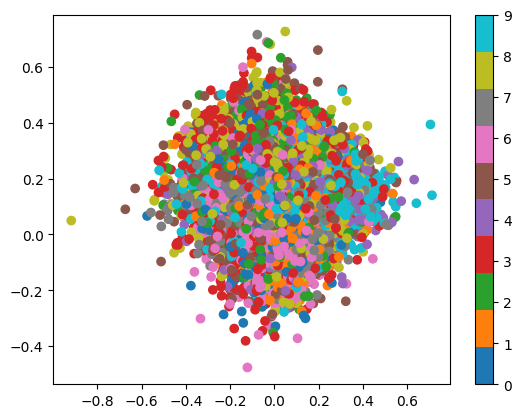

In [179]:
plot_latent(model, dataloader, batch_size, input_dim, 1875)

Plotting Distribution: 100%|████████████████████████████████████████████| 60000/60000 [00:13<00:00, 4366.94Sample(s)/s]


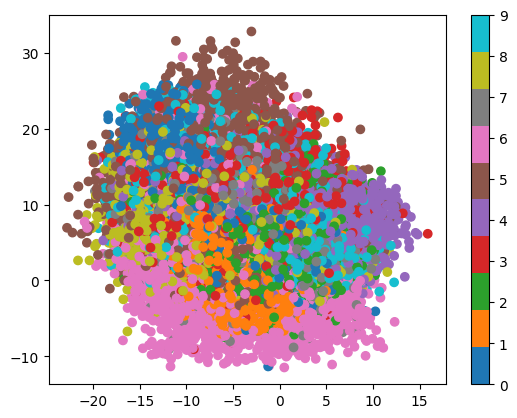

In [182]:
plot_latent(model, dataloader, batch_size, input_dim, 1875)

In [149]:
plot_reconstructed(model)

AttributeError: 'VariationalAutoEncoder' object has no attribute 'decoder'

In [148]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

In [ ]:
def inference(digit, num_examples=1):
    """
    Generates (num_examples) of a particular digit.
    Specifically we extract an example of each digit,
    then after we have the mu, sigma representation for
    each digit we can sample from that.

    After we sample we can run the decoder part of the VAE
    and generate examples.
    """
    images = []
    idx = 0
    for x, y in dataset:
        if y == idx:
            images.append(x)
            idx += 1
        if idx == 10:
            break

    encodings_digit = []
    for d in range(10):
        with torch.no_grad():
            mu, sigma = model.encode(images[d].view(1, 784))
        encodings_digit.append((mu, sigma))

    mu, sigma = encodings_digit[digit]
    for example in range(num_examples):
        epsilon = torch.randn_like(sigma)
        z = mu + sigma * epsilon
        out = model.decode(z)
        out = out.view(-1, 1, 28, 28)
        save_image(out, f"generated_{digit}_ex{example}.png")

for idx in range(10):
    inference(idx, num_examples=5)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))

class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z
    
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [159]:
import torch
from torch import nn

#divide into encoder decoder better for programming leter on
class VariationalAutoEncoder(nn.Module):
    def __init__(self, input_dim, h_dim=200, z_dim=20):
        super().__init__()
        # encoder
        self.img_2hid = nn.Linear(input_dim, h_dim)
        self.hid_2mu = nn.Linear(h_dim, z_dim)
        self.hid_2sigma = nn.Linear(h_dim, z_dim)

        # decoder
        self.z_2hid = nn.Linear(z_dim, h_dim)
        self.hid_2img = nn.Linear(h_dim, input_dim)

        self.relu = nn.ReLU()

    def encode(self, x):
        h = self.relu(self.img_2hid(x))
        mu, sigma = self.hid_2mu(h), self.hid_2sigma(h)
        epsilon = torch.randn_like(sigma)
        z = mu + sigma*epsilon
        return z, mu, sigma

    def decode(self, z):
        h = self.relu(self.z_2hid(z))
        return torch.sigmoid(self.hid_2img(h))

    def forward(self, x):
        z, mu, sigma = self.encode(x)
        x_reconstructed = self.decode(z)
        return x_reconstructed, mu, sigma